In [9]:
import pandas as pd
import sqlite3
import regex as re
import spacy

import re
from collections import defaultdict

In [4]:
# Read database (from HW1) into a DataFrame
con = sqlite3.connect("wiki_articles_hw1.db")

cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

df = pd.read_sql_query("SELECT * from wiki_articles_hw1", con)

con.close()

nlp = spacy.load("en_core_web_lg")
df

[('wiki_articles_hw1',)]


,title,text,name,url,datePublished,dateModified,headline
0,Abuse case,"From Wikipedia, the free encyclopedia\n\n\nAbu...",Abuse case,https://en.wikipedia.org/wiki/Abuse_case,2010-03-19T13:30:06Z,2021-10-30T20:20:23Z,specification model for security requirements ...
1,Access-control list,"From Wikipedia, the free encyclopedia\n\n\nLis...",Access-control list,https://en.wikipedia.org/wiki/Access-control_list,2002-07-12T08:06:50Z,2024-08-11T10:37:11Z,list associated with a computing system resour...
2,Antivirus software,"From Wikipedia, the free encyclopedia\n\n\nCom...",Antivirus software,https://en.wikipedia.org/wiki/Antivirus_software,2003-07-16T00:29:07Z,2024-09-05T15:59:54Z,computer security software that is used to pre...
3,Application security,"From Wikipedia, the free encyclopedia\n\n\nMea...",Application security,https://en.wikipedia.org/wiki/Application_secu...,2005-08-29T21:54:46Z,2024-09-04T21:24:46Z,measures taken to improve the security of an a...
4,Application firewall,"From Wikipedia, the free encyclopedia\n\n\nLay...",Application firewall,https://en.wikipedia.org/wiki/Application_fire...,2004-09-04T01:27:44Z,2024-04-29T22:37:28Z,a form of firewall that controls input/output ...
...,...,...,...,...,...,...,...
80,Threat model,"From Wikipedia, the free encyclopedia\n\n\nPro...",Threat model,https://en.wikipedia.org/wiki/Threat_model,2006-04-04T11:57:04Z,2024-09-05T19:37:03Z,"process by which potential threats, such as st..."
81,Trojan horse (computing),"From Wikipedia, the free encyclopedia\n\n\nTyp...",Trojan horse (computing),https://en.wikipedia.org/wiki/Trojan_horse_(co...,2001-09-28T02:09:56Z,2024-09-08T09:42:07Z,"A Trojan horse, or Trojan, is a type of malici..."
82,Vulnerability (computer security),"From Wikipedia, the free encyclopedia\n\n(Redi...",Vulnerability (computer security),https://en.wikipedia.org/wiki/Vulnerability_(c...,2004-11-03T21:22:10Z,2024-07-19T02:58:33Z,security weakness which allows an attacker to ...
83,Vulnerability scanner,"From Wikipedia, the free encyclopedia\n\n\nPro...",Vulnerability scanner,https://en.wikipedia.org/wiki/Vulnerability_sc...,2003-05-28T07:44:42Z,2024-08-03T02:06:48Z,software or other tool for probing computer sy...


In [5]:
df.columns

Index(['title', 'text', 'name', 'url', 'datePublished', 'dateModified',
       'headline'],
      dtype='object')

In [6]:
# POS tagging function
def pos_tag(d):
    doc = nlp(d)
    data = {
        "token_text": [token.text for token in doc],
        "token_pos": [token.pos_ for token in doc],
        "token_tag": [token.tag_ for token in doc],
        "token_lemma": [token.lemma_ for token in doc]
    }
    return pd.DataFrame(data)

# Noun chunks function
def noun_chunks(d):
    doc = nlp(d)
    data = {
        "chunk_text": [chunk.text for chunk in doc.noun_chunks]
    }
    return pd.DataFrame(data)

# Wrapper function to apply both pos_tag and noun_chunks
def process_text(text):
    pos_df = pos_tag(text)  # Get POS tags
    noun_chunk_df = noun_chunks(text)  # Get Noun chunks
    
    # Combine both DataFrames for each text
    combined_df = pd.concat([pos_df, noun_chunk_df], axis=1)
    
    return combined_df

# Example usage on your DataFrame
df['processed'] = df['text'].apply(process_text)

In [7]:
# Step 1: Text preprocessing function
def clean_text(text):
    # Remove lines starting with "From Wikipedia, the free encyclopedia"
    text = re.sub(r"From Wikipedia, the free encyclopedia.*", "", text)
    
    # Remove footer content starting with "Retrieved from...", "Category:", or "Categories:"
    text = re.sub(r"Retrieved from.*", "", text)
    text = re.sub(r"Category:.*", "", text)
    text = re.sub(r"Categories:.*", "", text)
    
    # Remove square brackets and their contents (e.g., [5], [edit])
    text = re.sub(r"\[.*?\]", "", text)
    
    # Replace "\n" with space
    text = text.replace("\n", " ")
    
    return text.strip()

# Step 2: Function to create a spaCy document
def create_spacy_doc(text):
    return nlp(text)

# Step 3: Extract noun chunks containing at least one space
def extract_noun_chunks(doc):
    noun_chunks_count = defaultdict(int)
    
    for chunk in doc.noun_chunks:
        chunk_text = chunk.text.strip().lower()
        if " " in chunk_text:  # Keep only noun chunks that contain at least one space
            noun_chunks_count[chunk_text] += 1
    
    return noun_chunks_count

# Step 4: Extract lemmas for "NOUN" and "PROPN" and create reverse word index
def extract_lemmas(doc, doc_num, reverse_word_index):
    for token in doc:
        if token.pos_ in ["NOUN", "PROPN"] and len(token.lemma_) > 1:
            lemma = token.lemma_.lower()
            reverse_word_index[lemma].append(doc_num)

# Main processing loop
def process_texts(df):
    # Initialize the defaultdict for noun chunks and reverse word index for lemmas
    noun_chunks_global = defaultdict(int)
    reverse_word_index = defaultdict(list)
    
    for i, text in enumerate(df['text']):
        # Step 1: Clean the text
        cleaned_text = clean_text(text)
        
        # Step 2: Create spaCy document
        doc = create_spacy_doc(cleaned_text)
        
        # Step 3: Extract noun chunks
        noun_chunks_local = extract_noun_chunks(doc)
        for chunk, count in noun_chunks_local.items():
            noun_chunks_global[chunk] += count
        
        # Step 4: Extract lemmas and populate the reverse word index
        extract_lemmas(doc, i, reverse_word_index)
    
    return noun_chunks_global, reverse_word_index


In [10]:
noun_chunks_global, reverse_word_index = process_texts(df)

# Display the results
print("Noun Chunks Frequency:")
for chunk, count in noun_chunks_global.items():
    print(f"{chunk}: {count}")
    
print("\nReverse Word Index:")
for lemma, doc_list in reverse_word_index.items():
    print(f"{lemma}: {doc_list}")

Noun Chunks Frequency:
abuse case: 1
a specification model: 1
security requirements: 18
the software development industry: 2
the term abuse case: 1
an adaptation: 1
use case: 4
the term: 35
john mcdermott: 2
chris fox: 2
computer science department: 1
the james madison university: 1
its authors: 3
an abuse case: 1
a type: 22
complete interaction: 1
a system: 92
one or more actors: 1
the results: 17
the interaction: 1
the system: 199
the actors: 2
the stakeholders: 6
coherent transactions: 1
actual harm: 1
a complete abuse case: 1
an interaction: 1
an actor: 1
a resource: 13
their notation: 1
misuse cases: 13
chun wei: 2
abuse cases: 4
overview use cases: 2
required behaviour: 2
other products: 2
essentially structured stories: 2
the normal behavior: 2
the software: 108
the uml notation: 2
those systems: 2
use abuse cases: 1
the field: 23
security requirements elicitation: 1
an abuse case diagram: 1
a corresponding use case diagram: 2
the same diagram: 1
misuse case: 6
no new terminolog

In [11]:
from collections import Counter

# Function to get the 10 most common noun chunks
def most_common_noun_chunks(noun_chunks_global, n=10):
    # Use Counter to find the most common noun chunks
    noun_chunks_counter = Counter(noun_chunks_global)
    return noun_chunks_counter.most_common(n)

# Example usage: Get the 10 most frequent noun chunks
most_common_chunks = most_common_noun_chunks(noun_chunks_global, 10)

# Display the result
for chunk, count in most_common_chunks:
    print(f"Noun Chunk: '{chunk}', Frequency: {count}")


Noun Chunk: 'the original', Frequency: 787
Noun Chunk: 'the system', Frequency: 199
Noun Chunk: 'the user', Frequency: 159
Noun Chunk: 'the attacker', Frequency: 128
Noun Chunk: 'the software', Frequency: 108
Noun Chunk: 'information security', Frequency: 107
Noun Chunk: 'the wayback machine', Frequency: 101
Noun Chunk: 'a system', Frequency: 92
Noun Chunk: 'the internet', Frequency: 91
Noun Chunk: 'an attacker', Frequency: 91


In [13]:
num_keys_in_reverse_word_index = len(reverse_word_index)

# Display the result
print(f"Number of keys in the reverse word index: {num_keys_in_reverse_word_index}")


Number of keys in the reverse word index: 14495


In [14]:
# Function to find lemmas that appear in at least 50 texts/documents
def lemmas_in_50_or_more_docs(reverse_word_index, min_docs=50):
    # Create a list to store lemmas that appear in at least 50 documents
    frequent_lemmas = []
    
    # Loop through the reverse word index
    for lemma, docs in reverse_word_index.items():
        if len(set(docs)) >= min_docs:  # Check if lemma appears in at least 'min_docs' documents
            frequent_lemmas.append(lemma)
    
    return frequent_lemmas

# Example usage: Get lemmas that appear in at least 50 documents
lemmas_50_or_more = lemmas_in_50_or_more_docs(reverse_word_index, 50)

# Display the result
lemmas_50_or_more


['case',
 'model',
 'security',
 'software',
 'use',
 'computer',
 'type',
 'system',
 'resource',
 'threat',
 'reference',
 'analysis',
 'pdf',
 'list',
 'access',
 'control',
 'object',
 'user',
 'process',
 'file',
 'operating',
 'data',
 'program',
 'privilege',
 'december',
 'source',
 'internet',
 'part',
 'network',
 'example',
 'way',
 'service',
 'information',
 'hardware',
 'attack',
 'sql',
 'management',
 'organization',
 'datum',
 'level',
 'problem',
 'computing',
 'may',
 'original',
 'july',
 'september',
 'protection',
 'history',
 'digital',
 'code',
 'time',
 'execution',
 'secure',
 'technology',
 'encryption',
 'web',
 'link',
 'systems',
 'detection',
 'application',
 'risk',
 'design',
 'method',
 'approach',
 'form',
 'technique',
 'category',
 'article',
 'october',
 'browser',
 'site',
 'breach',
 'tool',
 'isbn',
 'injection',
 'exploit',
 'social',
 'engineering',
 'vulnerability',
 'authentication',
 'factor',
 'intrusion',
 'event']

In [15]:
# Function to count unique lemmas that occur in only one document
def lemmas_in_one_doc(reverse_word_index):
    count = 0
    
    # Loop through the reverse word index
    for lemma, docs in reverse_word_index.items():
        if len(set(docs)) == 1:  # Check if lemma appears in exactly one document
            count += 1
    
    return count

# Example usage: Get the count of unique lemmas that occur in only one document
lemmas_in_one_doc_count = lemmas_in_one_doc(reverse_word_index)

# Display the result
lemmas_in_one_doc_count


9480

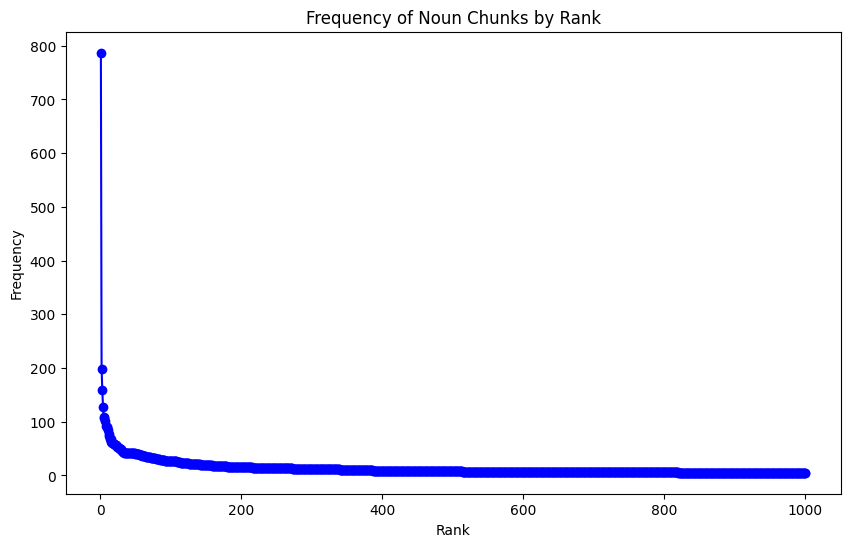

In [16]:
import matplotlib.pyplot as plt
from collections import Counter

# Function to get the most common noun chunks
def most_common_noun_chunks(noun_chunks_global, n=1000):
    # Use Counter to find the most common noun chunks
    noun_chunks_counter = Counter(noun_chunks_global)
    return noun_chunks_counter.most_common(n)

# Example: Get the 1000 most common noun chunks (adjust accordingly in practice)
most_common_chunks = most_common_noun_chunks(noun_chunks_global, 1000)

# Separate the data into ranks and frequencies
ranks = list(range(1, len(most_common_chunks) + 1))  # X-axis (Rank)
frequencies = [count for chunk, count in most_common_chunks]  # Y-axis (Frequency)

# Create the line chart
plt.figure(figsize=(10, 6))
plt.plot(ranks, frequencies, marker='o', linestyle='-', color='b')

# Label the axes
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Frequency of Noun Chunks by Rank')

# Show the plot
plt.show()


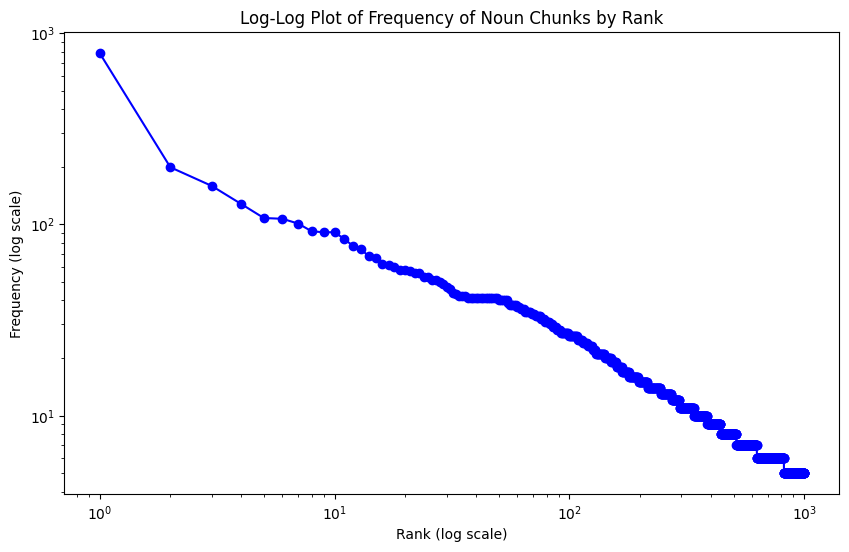

In [17]:
# Create a log-log plot for the same data
plt.figure(figsize=(10, 6))
plt.plot(ranks, frequencies, marker='o', linestyle='-', color='b')

# Set log scale for both axes
plt.xscale('log')
plt.yscale('log')

# Label the axes
plt.xlabel('Rank (log scale)')
plt.ylabel('Frequency (log scale)')
plt.title('Log-Log Plot of Frequency of Noun Chunks by Rank')

# Show the plot
plt.show()


### Impact of Rare Terms in Co-occurrence Analysis

Including rare terms in co-occurrence analysis can affect results in the following ways:

- **Noise**: Rare terms appear infrequently, adding noise and making it hard to identify true co-occurrences.
- **Skewed Metrics**: Metrics like PMI or Chi-squared tests can inflate the significance of rare terms, leading to misleading results.
- **Overfitting**: Models may overfit to rare terms, reducing generalizability.

### Solutions

- **Term Frequency Thresholding**: Set a minimum frequency to filter out rare terms, reducing noise.
- **Smoothing**: Use smoothing (e.g., Laplace) to handle low co-occurrence counts, preventing inflated significance.
- **Weighting (TF-IDF)**: Apply TF-IDF to downplay rare terms and prevent them from skewing co-occurrence metrics.
- **Randomization Tests**: Shuffle terms/documents to identify statistically significant co-occurrences.

### Impact of Misleading Values

False significance can lead to faulty clusters, misclassifications, and incorrect graphs, reducing model accuracy.

### Why These Solutions Work

- **Thresholding** uses sufficient data, improving reliability.
- **Smoothing** adjusts small probabilities, reducing noise.
- **TF-IDF** reduces the influence of rare terms.
- **Randomization** lowers the risk of overfitting or false positives.
